<IPython.core.display.Javascript object>


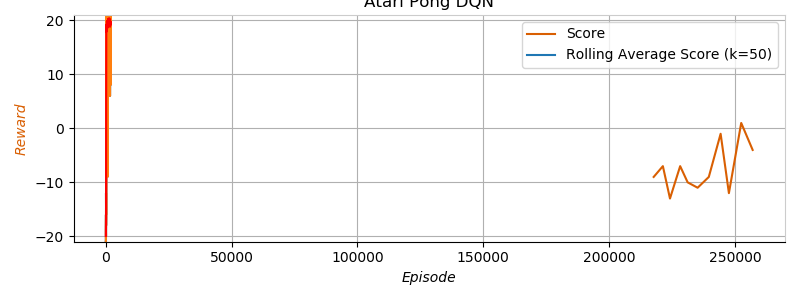

In [10]:
%matplotlib notebook
import tensorwatch as tw
import time

# streams will be stored in test.log file
client = tw.WatcherClient()

# create a stream for logging
stream = client.create_stream(expr='lambda d: (d.frames, d.episode_score)')

line_plot = tw.Visualizer(stream, vis_type='line', xtitle="Frames", ytitle="Reward", yrange=(-21,21))
line_plot.show()

In [26]:
avg_stream = client.create_stream(expr='lambda d:(d.frames, d.total_score/d.episode)')
avg_plot = tw.Visualizer(avg_stream, vis_type='line', host=line_plot, xtitle='Frames', ytitle='Average Reward', yrange=(-21,21))
avg_plot.show()

In [2]:
from models import Qnet
q = Qnet(84,84,4,4)
tw.model_stats(q,[1,4,84,84])

,module name,input shape,output shape,params,memory(MB),MAdd,Flops,MemRead(B),MemWrite(B),duration[%],MemR+W(B)
0,conv1,4 84 84,32 20 20,8224.0,0.05,"6,553,600.0","3,289,600.0",145792.0,51200.0,64.00%,196992.0
1,bn1,32 20 20,32 20 20,64.0,0.05,"51,200.0","25,600.0",51456.0,51200.0,2.56%,102656.0
2,conv2,32 20 20,64 9 9,32832.0,0.02,"5,308,416.0","2,659,392.0",182528.0,20736.0,6.51%,203264.0
3,bn2,64 9 9,64 9 9,128.0,0.02,"20,736.0","10,368.0",21248.0,20736.0,0.81%,41984.0
4,conv3,64 9 9,64 7 7,36928.0,0.01,"3,612,672.0","1,809,472.0",168448.0,12544.0,7.11%,180992.0
5,bn3,64 7 7,64 7 7,128.0,0.01,"12,544.0","6,272.0",13056.0,12544.0,0.76%,25600.0
6,head.0,3136,512,1606144.0,0.00,"3,210,752.0","1,605,632.0",6437120.0,2048.0,16.85%,6439168.0
7,head.1,512,512,0.0,0.00,512.0,512.0,2048.0,2048.0,0.60%,4096.0
8,head.2,512,4,2052.0,0.00,"4,092.0","2,048.0",10256.0,16.0,0.80%,10272.0
total,,,,1686500.0,0.17,"18,774,524.0","9,408,896.0",10256.0,16.0,100.00%,7205024.0


In [6]:
import pandas as pd
from matplotlib import pyplot as plt

def convert_line_to_dict(line):
    out_dict = {}
    lines = [l.strip() for l in line.strip().split(',')]
    for kv in lines:
        k,v = kv.split(':')
        k=k.strip()
        v=v.strip()
        out_dict[k] = float(v.replace('%',''))
    return out_dict

def load_stats_from_logging(logging_file):
    with open(logging_file,'r') as f:
        lines = f.readlines()
    dicts = [convert_line_to_dict(line) for line in lines]
    return pd.DataFrame(dicts)


def load_multiple_models(model_log_files):
    return [load_stats_from_logging(log_file) for log_file in model_log_files]

In [34]:
def plot_x_vs_y(x, y, xlab, ylab, models, legend, episode_start = 0, episode_end = None):
    plt.figure(figsize=(20,10))
    
    for m in models:
        plt.plot(m.iloc[episode_start:episode_end][x], m.iloc[episode_start:episode_end][y])
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title("Atari Pong")
    plt.legend(legend)
    plt.show()
def plot_episode_vs_reward(models, model_legend, episode_start = 0, episode_end=None):
    plot_x_vs_y('n_episode', 'Episode Score', 'Episode', 'Reward', models, model_legend, episode_start, episode_end)
    
def plot_episode_vs_reward_rolling(models, model_legend, episode_start = 0, episode_end=None, k=1):
    models = [m.rolling(k).mean() for m in models]
    plot_episode_vs_reward(models, model_legend, episode_start, episode_end)

def plot_frames_vs_reward(models, model_legend, episode_start = 0, episode_end=None):
    plot_x_vs_y('Total Frames', 'Episode Score', 'Frames', 'Reward', models, model_legend, episode_start, episode_end)
    
def plot_frames_vs_reward_rolling(models, model_legend, episode_start = 0, episode_end=None, k=1):
    models = [m.rolling(k).mean() for m in models]
    plot_frames_vs_reward(models, model_legend, episode_start, episode_end)

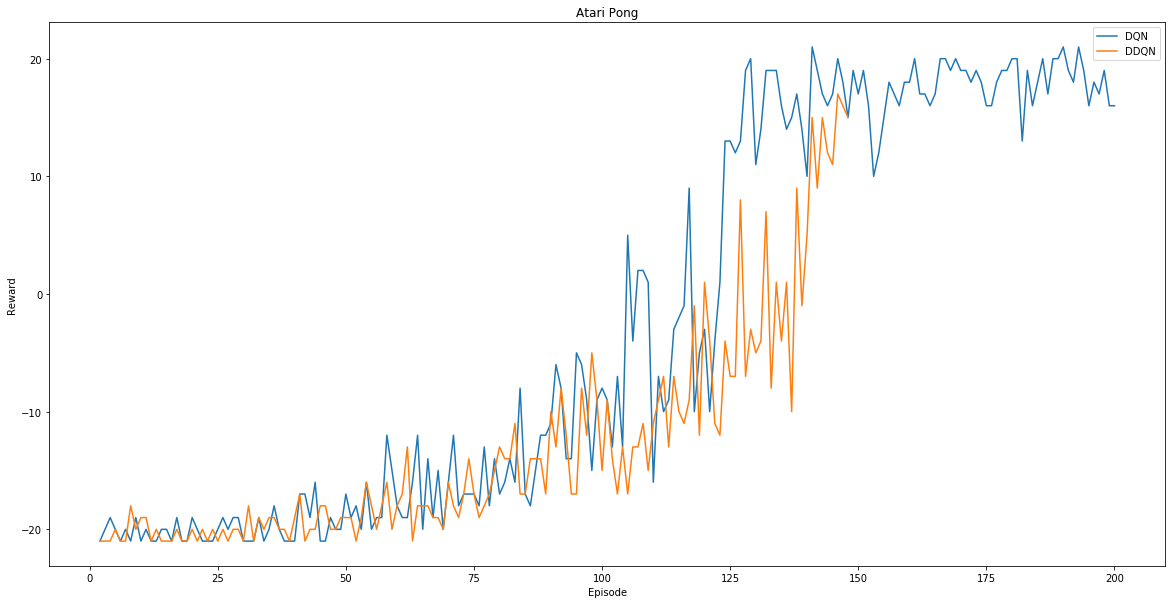

In [35]:
legend = ['DQN', 'DDQN']
models = ['log/dqn.out', 'log/ddqn.out']
dfs = load_multiple_models(models)
plot_episode_vs_reward(dfs, legend, 1, 200)

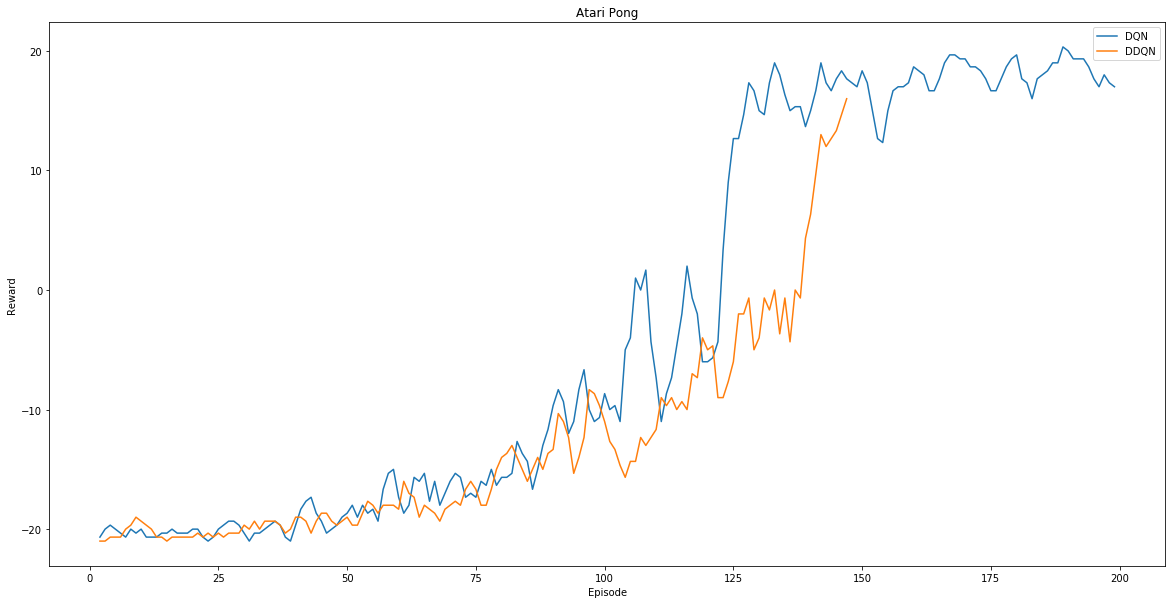

In [36]:
plot_episode_vs_reward_rolling(dfs, legend, 1, 200, 3)

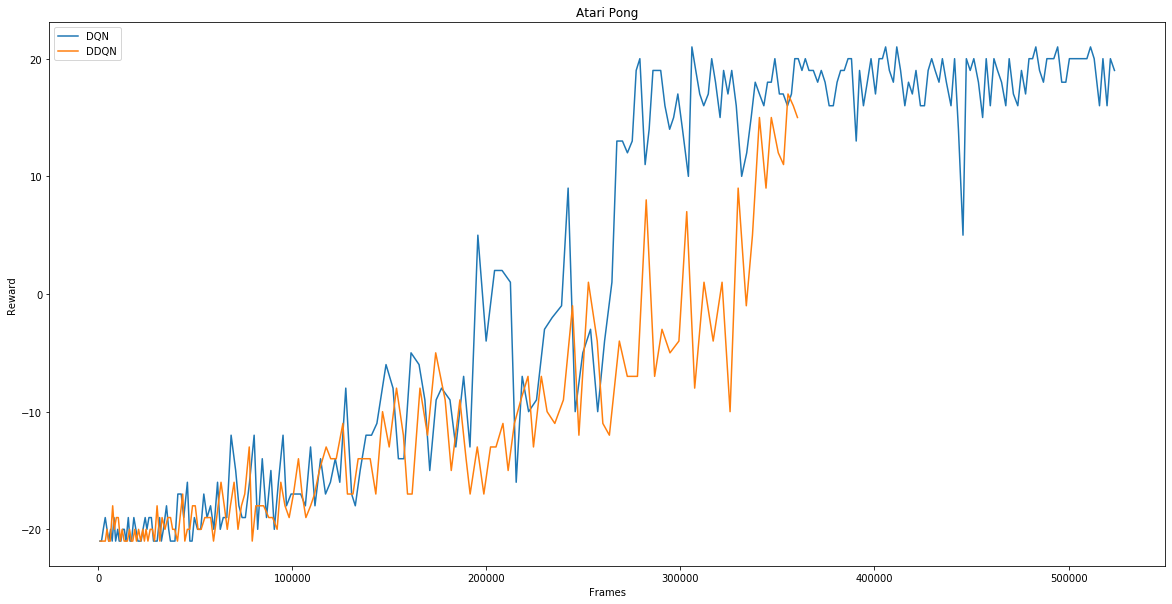

In [41]:
plot_frames_vs_reward(dfs, legend, 0, 250)

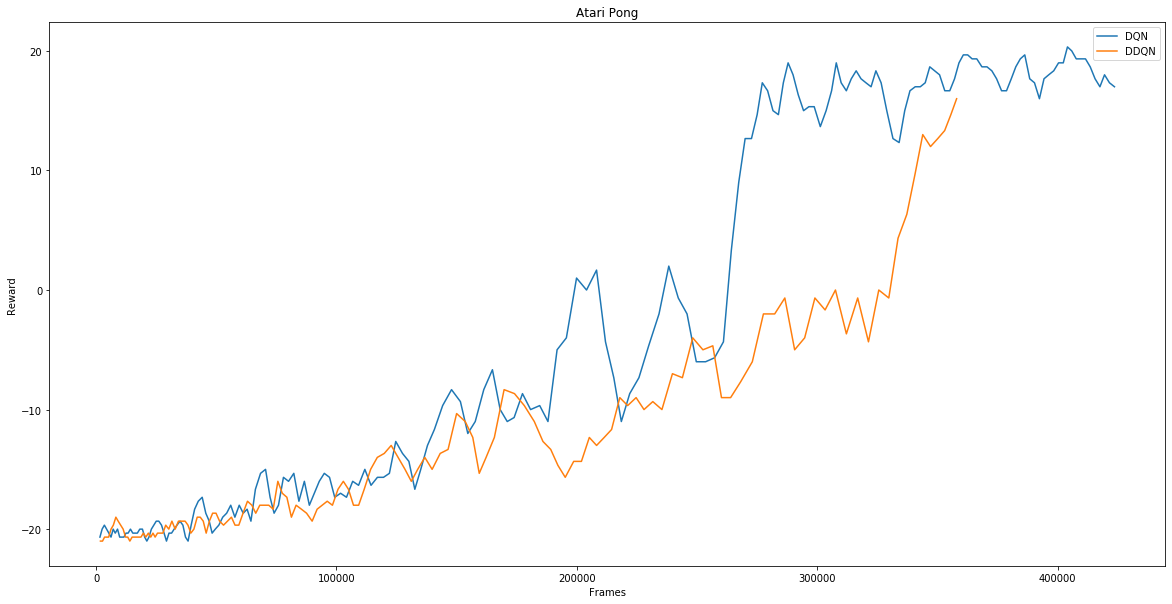

In [42]:
plot_frames_vs_reward_rolling(dfs, legend, 0, 200, 3)

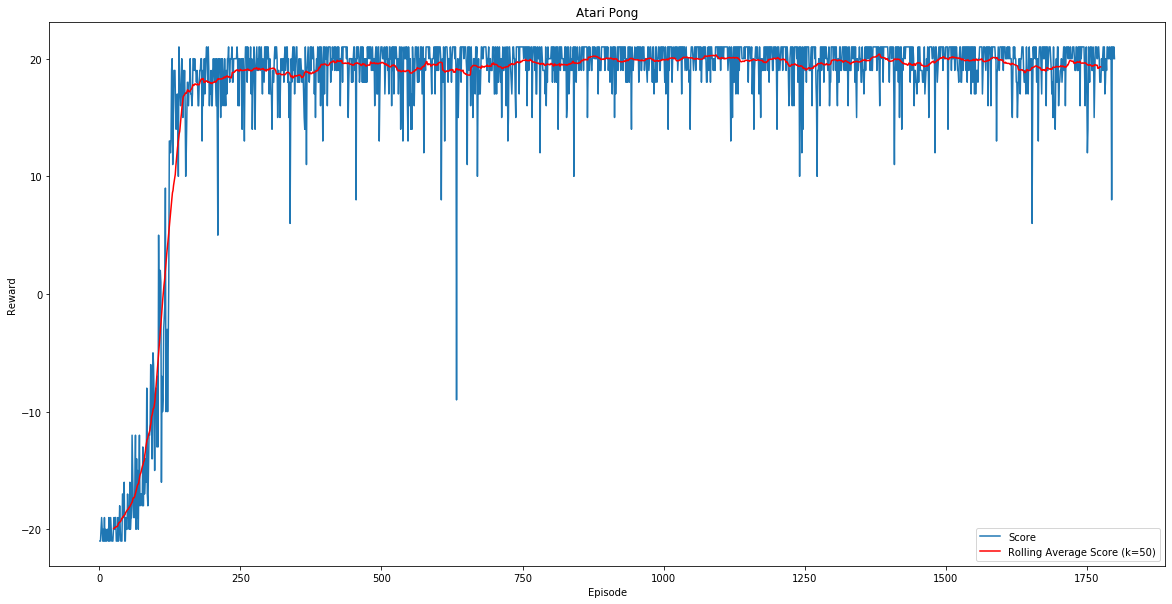

In [37]:
rolling_df = df.rolling(50).mean()
plt.figure(figsize=(20,10))
plt.plot(df['n_episode'], df['Episode Score'])
#plt.plot(df['Total Frames'], df['Average Score'])
plt.plot(rolling_df['n_episode'], rolling_df['Episode Score'], color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Atari Pong")
plt.legend(['Score', 'Rolling Average Score (k=50)'])
plt.show()